In [68]:
from pathlib import Path
import meshio
from mesh_handler import xdmf_to_meshes, meshes_to_xdmf, vtu_to_mesh, mesh_to_vtu,  accessing_mesh_data, create_mock_mesh
from preprocessing_utils import torch_input_edges, torch_input_edges, get_X_y
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
#Example use

# after executing preprocessing_utils.py with 4Students_AnXplore03 in the same directory
# a folder named "data_cleaned" will be created with the preprocessed mesh files
# the function get_X_y can be used to get the input and output data of mesh_id

#retrieve the list of all the mesh_ids
CWD = Path.cwd()
data_path = CWD / "data_cleaned"
xdmf_files = list(data_path.glob("*.pth"))
mesh_ids = [xdmf_file.name.split("_")[1].split(".")[0] for xdmf_file in xdmf_files]
print(mesh_ids)
mesh_id = mesh_ids[0]

X_nodes, X_edges, y = get_X_y(mesh_id, time_step=0)
print(X_nodes.shape)
print(X_edges.shape)
print(y.shape)

['1', '11', '117', '119-1', '119-2', '120', '121', '128', '129', '134', '135', '136', '137', '138', '139', '140', '142', '144-2', '148', '151', '152', '153', '155', '157', '158', '159', '161', '162', '163-1', '163-2', '164', '165', '166', '168-1', '168-2', '170', '171', '172', '173', '174', '175', '177', '178', '180', '181', '182-1', '182-2', '182-3', '183', '185', '186-1', '186-2', '187', '188', '189', '19', '191', '192', '193-1', '193-2', '194', '195', '196-1', '196-2', '197', '198-1', '198-2', '199', '2', '200', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '217', '219', '23', '25', '26', '28', '3', '31', '34', '40', '42-1', '42-2', '42-3', '44', '54-1', '54-2', '55', '6', '9-1']
torch.Size([11446, 7])
torch.Size([2, 71718])
torch.Size([11446, 4])


## data explo

In [71]:
mesh_id = mesh_ids[0]
data = torch.load(data_path / f"mesh_{mesh_id}.pth")
X_nodes_all, X_edges = data["nodes"], data["edges"]

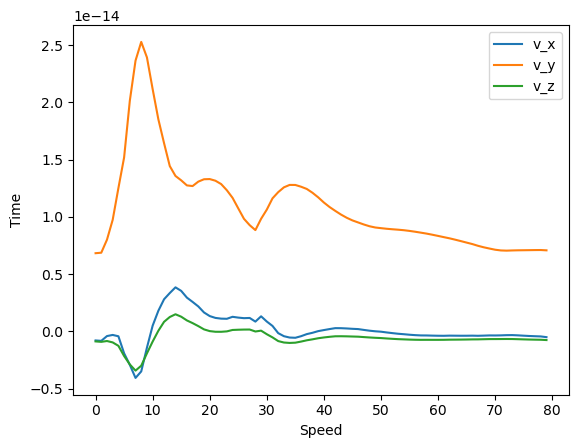

In [114]:
#speeds at node 800 across all time steps
plt.plot(X_nodes_all[:, 800, 3], label="v_x")
plt.plot(X_nodes_all[:, 800, 4], label="v_y")
plt.plot(X_nodes_all[:, 800, 5], label="v_z")
plt.xlabel("Speed")
plt.ylabel("Time")
plt.legend();

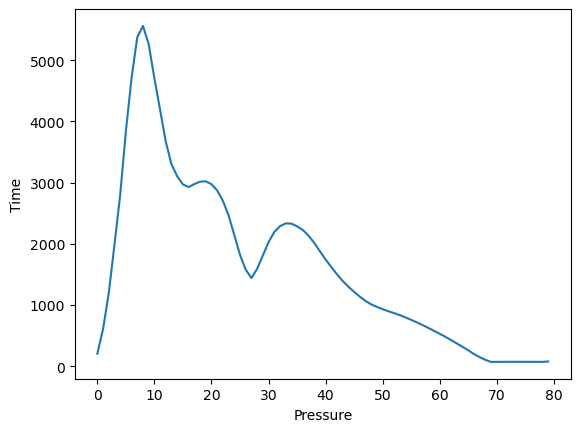

In [113]:
#pressure at node 800 across all time steps
plt.plot(X_nodes_all[:, 800, 6])
plt.xlabel("Pressure")
plt.ylabel("Time");

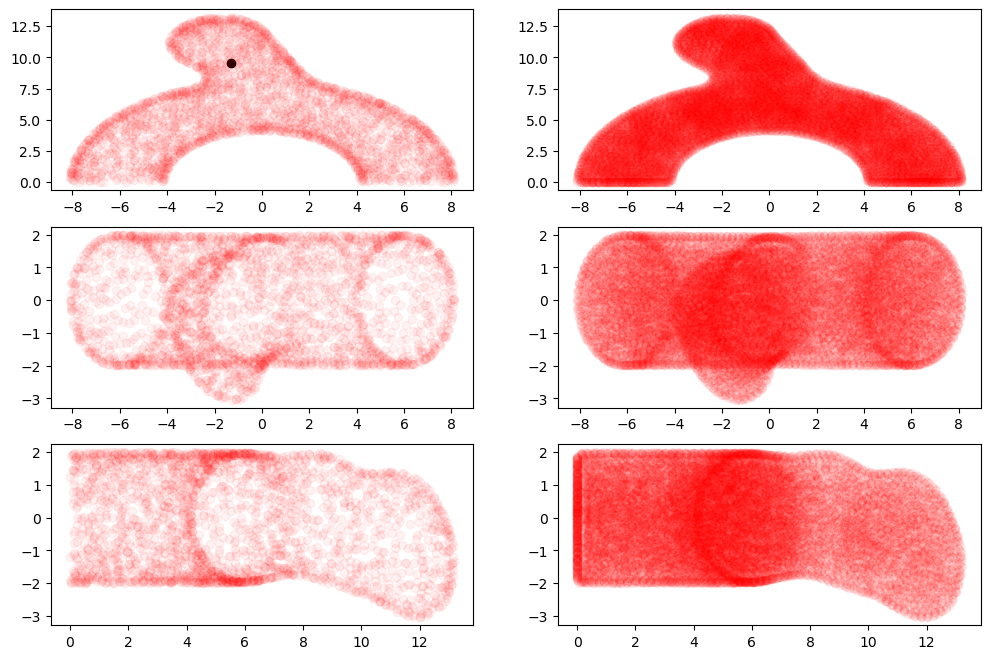

In [99]:
X_nodes_init = X_nodes_all[0]
velocities = torch.norm(X_nodes_init[:,3:6], p=2, dim=1)
border = torch.where(velocities < 1e-10)[0]
fig, ax = plt.subplots(3, 2, figsize=(12, 8))
sub_border = border[::2]
ax[0,0].plot(X_nodes_init[800, 0], X_nodes_init[800, 1], "ko")
ax[0,0].plot(X_nodes_init[sub_border, 0], X_nodes_init[sub_border, 1], "ro", alpha=0.05)
ax[0,1].plot(X_nodes_init[:, 0], X_nodes_init[:, 1], "ro", alpha=0.05)
ax[1,0].plot(X_nodes_init[sub_border, 0], X_nodes_init[sub_border, 2], "ro", alpha=0.05)
ax[1,1].plot(X_nodes_init[:, 0], X_nodes_init[:, 2], "ro", alpha=0.05);
ax[2,0].plot(X_nodes_init[sub_border, 1], X_nodes_init[sub_border, 2], "ro", alpha=0.05)
ax[2,1].plot(X_nodes_init[:, 1], X_nodes_init[:, 2], "ro", alpha=0.05);

In [35]:
def find_neighbors(edge_index, node):
    # Find all edges where the node is a source or target
    mask = (edge_index[0] == node) | (edge_index[1] == node)
    edges = edge_index[:, mask]
    
    # Extract neighbors
    neighbors = edges[1][edges[0] == node].tolist() + edges[0][edges[1] == node].tolist()
    
    # Remove duplicates and the node itself
    neighbors = list(set(neighbors) - {node})
    
    return neighbors

In [108]:
def custom_field_mesh(mesh_id: str, fields_dict, time_step: int = 0):
    meshes = xdmf_to_meshes(CWD / f"4Students_AnXplore03/AllFields_Resultats_MESH_{mesh_id}.xdmf", verbose=False)
    mesh_template = meshes[time_step]
    mesh_template.point_data = fields_dict
    return mesh_template

#Example use
if not (CWD / "vtus").exists():
    (CWD / "vtus").mkdir(exist_ok=True)

mesh_id = mesh_ids[0]
data = torch.load(data_path / f"mesh_{mesh_id}.pth")
X_nodes_all, X_edges = data["nodes"], data["edges"]
X_nodes_t = X_nodes_all[34]
velocities = torch.norm(X_nodes_t[:,3:6], p=2, dim=1)
border = torch.where(velocities < 1e-10)[0]
field = torch.zeros(X_nodes_t.shape[0], dtype=torch.float32)
field[border] = 1
dict_field = {"border": np.array(field), "velocities": np.array(velocities)}
mesh = custom_field_mesh(mesh_id, fields_dict=dict_field)
mesh_to_vtu(mesh, CWD / f"vtus/border_{mesh_id}_bordervelo.vtu")

Mesh saved to c:\Users\33783\Desktop\IDSC\hackathon\DC_flood\vtus\border_1_bordervelo.vtu


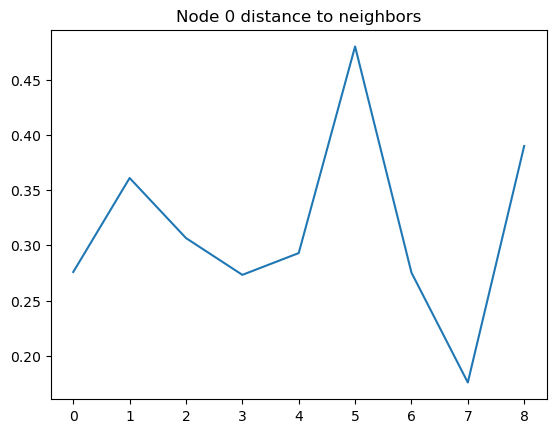

In [109]:
node = 0
neighbors = find_neighbors(X_edges, node)
plt.title(f"Node {node} distance to neighbors")
plt.plot([torch.norm(X_nodes_init[node, 0:3] - X_nodes_init[neighbor, 0:3], p=2) for neighbor in neighbors]);